# Import and setup

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum, CubicSplineInterpolant


from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

from few.waveform import (
    FastKerrEccentricEquatorialFlux,
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)

from few.utils.geodesic import get_fundamental_frequencies

import GWfuncs
import gc
import pickle
import os
import cupy as cp
import multiprocessing as mp
from multiprocessing import Queue, Process
from functools import partial
from SNR_tutorial_utils import LISA_Noise
from lisatools.sensitivity import *

from few.utils.constants import YRSID_SI, Gpc, MRSUN_SI



# import pandas as pd
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

In [2]:
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
#in the paper xI0 = 0.866, but that would be non-equatorial case

use_gpu = True 
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

# Generate amplitudes, trajectory, etc.

In [72]:
N_traj = 1000 # change amount of points here 
delta_T = T*YRSID_SI/N_traj 

In [73]:
# Calc trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=delta_T, upsample=True) 

t_gpu = cp.asarray(t)

# Get amplitudes along trajectory
teuk_modes = amp(a, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

In [74]:
dist = 1.0 # Gpc
factor = dist * Gpc / (m2 * MRSUN_SI)
N_traj = teuk_modes.shape[0]  # number of trajectory points

# Interpolate -> sum (one full waveform)

Still have problems with NaNs

In [75]:
%%time

t_gpu = cp.asarray(t)

# need to prepare arrays for sum with all modes due to +/- m setup
ls = amp.l_arr[: teuk_modes.shape[1]]
ms = amp.m_arr[: teuk_modes.shape[1]]
ns = amp.n_arr[: teuk_modes.shape[1]]

keep_modes = np.arange(teuk_modes.shape[1])
temp2 = keep_modes * (keep_modes < amp.num_m0) + (keep_modes + amp.num_m_1_up) * (
    keep_modes >= amp.num_m0
) 

ylmkeep = np.concatenate([keep_modes, temp2])
ylms_in = ylms[ylmkeep]
teuk_modes_in = teuk_modes

cp.cuda.Stream.null.synchronize()

CPU times: user 1.52 ms, sys: 930 μs, total: 2.45 ms
Wall time: 2.04 ms


In [76]:
%%time

# perform summation
waveform1 = interpolate_mode_sum(
    t_gpu,
    teuk_modes_in,
    ylms_in,
    traj.integrator_spline_t,
    traj.integrator_spline_phase_coeff[:, [0, 2]],
    ls,
    ms,
    ns,
    dt=dt,
    T=T,
)

cp.cuda.Stream.null.synchronize()

CPU times: user 1min 9s, sys: 216 ms, total: 1min 9s
Wall time: 1min 9s


In [77]:
waveform1[~np.isnan(waveform1)]

array([0.21930317+0.1927499j , 0.21929172+0.19276287j,
       0.2192803 +0.1927758j , ..., 0.11547298+0.13796755j,
       0.11547295+0.13796758j, 0.11547291+0.13796761j], shape=(34714,))

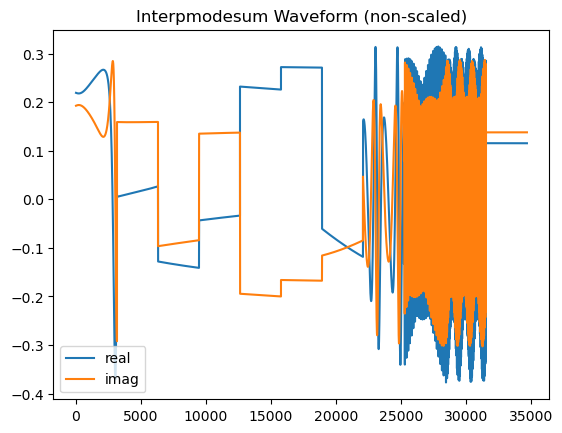

In [78]:
plt.plot(waveform1.get().real, label='real')
plt.plot(waveform1.get().imag, label='imag')
plt.title('Interpmodesum Waveform (non-scaled)')
plt.legend(loc='lower left')
plt.show()

# Interpolate 1 mode with interpmodesum

In [79]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [80]:
mode_idx = 1

In [81]:
%%time

# interpolate only one mode 
waveform1_1 = interpolate_mode_sum(
    t_gpu,
    teuk_modes_in[:, mode_idx:mode_idx+1],
    ylms_in[mode_idx:mode_idx+1],
    traj.integrator_spline_t,
    traj.integrator_spline_phase_coeff[:, [0, 2]],
    ls[mode_idx:mode_idx+1],
    ms[mode_idx:mode_idx+1],
    ns[mode_idx:mode_idx+1],
    dt=dt,
    T=T,
)

cp.cuda.Stream.null.synchronize()

CPU times: user 31.9 ms, sys: 3.26 ms, total: 35.1 ms
Wall time: 34.9 ms


In [82]:
waveform1_1[~np.isnan(waveform1_1)]

array([-1.47868018e-19+6.48565825e-20j, -1.47199009e-19+6.63611318e-20j,
       -1.46515818e-19+6.78563508e-20j, ...,
       -1.09861118e-19+1.21208194e-19j, -1.09861462e-19+1.21207959e-19j,
       -1.09861806e-19+1.21207724e-19j], shape=(34714,))

In [83]:
np.sum(~np.isnan(waveform1_1))/len(waveform1_1) * 100

array(1.10110193)

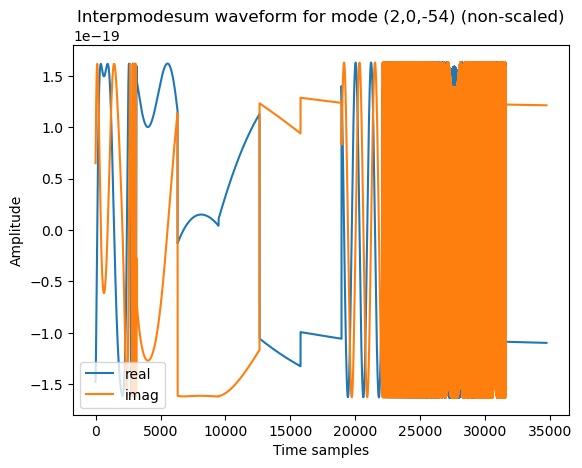

In [84]:
plt.plot(waveform1_1.get().real, label='real')
plt.plot(waveform1_1.get().imag, label='imag')
plt.title(f'Interpmodesum waveform for mode {mode_labels[mode_idx]} (non-scaled)')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.legend(loc='lower left')
plt.show()

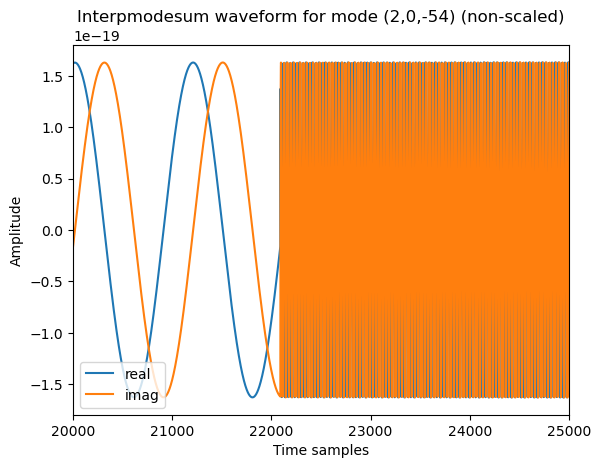

In [94]:
plt.plot(waveform1_1.get().real, label='real')
plt.plot(waveform1_1.get().imag, label='imag')
plt.title(f'Interpmodesum waveform for mode {mode_labels[mode_idx]} (non-scaled)')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.legend(loc='lower left')
plt.xlim(2e4,2.5e4)
plt.show()

# Interpolate 1 mode with CubicSpineInterpolant

In [87]:
%%time

# selecting one mode
mode_real = teuk_modes[:, mode_idx].real 
mode_imag = teuk_modes[:, mode_idx].imag
mode_all = np.vstack([mode_real, mode_imag])

# interpolation
spline = CubicSplineInterpolant(t, mode_all, force_backend="cuda12x")

# dense sampling
t_new = np.linspace(t[0], t[-1], int(T*YRSID_SI/dt))

# evaluating the spline at new dense time array
interp_mode = spline(t_new)
interp_mode_comp = interpolated_mode[0] + 1j * interpolated_mode[1]

CPU times: user 130 ms, sys: 36.2 ms, total: 166 ms
Wall time: 164 ms


In [88]:
np.sum(~np.isnan(interp_mode_comp))/len(interp_mode_comp) * 100

array(100.)

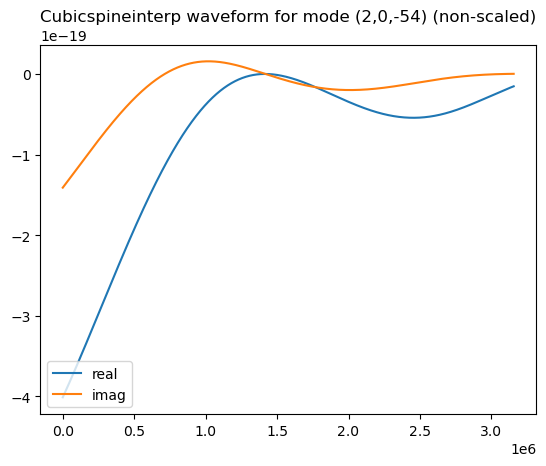

In [90]:
plt.plot(interp_mode_comp.get().real, label='real')
plt.plot(interp_mode_comp.get().imag, label='imag')
plt.title(f'Cubicspineinterp waveform for mode {mode_labels[mode_idx]} (non-scaled)')
plt.legend(loc='lower left')
plt.show()